In [1]:
import pandas as pd 
import quandl
import math, datetime
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use('ggplot')

/home/dan/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = quandl.get('WIKI/GOOGL') 
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Close'] * 100.0
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
print(len(df))

3424


In [3]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)




X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

In [4]:
df.dropna(inplace=True)
y = np.array(df['label'])
print(len(X),len(y))

3389 3389


In [5]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

#linear regression
clf = LinearRegression()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.9769223061977924


In [6]:
#saving the training in a pickle file
with open('linearRegression.pickle', 'wb') as f:
    pickle.dump(clf,f)
    

In [7]:
#loading the training
pickle_in = open('linearRegression.pickle', 'rb')
clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, y_test)
print(accuracy)

0.9769223061977924


In [8]:
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)
df['Forecast'] = np.nan

[1101.62256166 1070.63152433 1018.16252377 1059.55409387 1071.12910883
 1071.46591841 1090.332215   1109.1655529  1112.60684206 1120.93103526
 1130.3879201  1127.12169471 1146.49753347 1162.1541341  1133.7489255
 1120.13756879 1086.08468053 1101.70547856 1112.54015543 1118.85328863
 1133.28002506 1147.63137313 1179.2503417  1183.54746213 1155.61142312
 1166.50588102 1168.32681358 1150.87690042 1116.28720033 1112.79700483
 1110.96499945 1068.04943254 1040.96517443 1070.88182934 1019.60350235] 0.9769223061977924 35


In [9]:
last_date = df.iloc[-1].name # gets the date of the last
print(last_date)
last_unix = last_date.timestamp() #seconds between 1970 and the lastdate
print(last_unix)
one_day = 86400 # seconds in one day
next_unix = last_unix + one_day
#print(next_unix)

2018-02-05 00:00:00
1517788800.0


In [10]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)# the date after 1970 + next_unix seconds
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i] #insert the new date as index and NaN for all features except forecast and there inserts the prediccion of the last 35 days

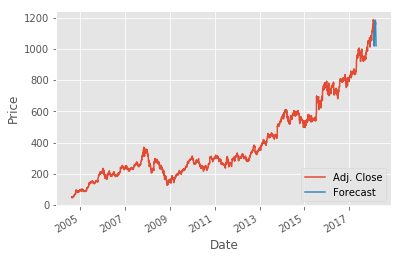

In [11]:
#'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()